<Axes: xlabel='date'>

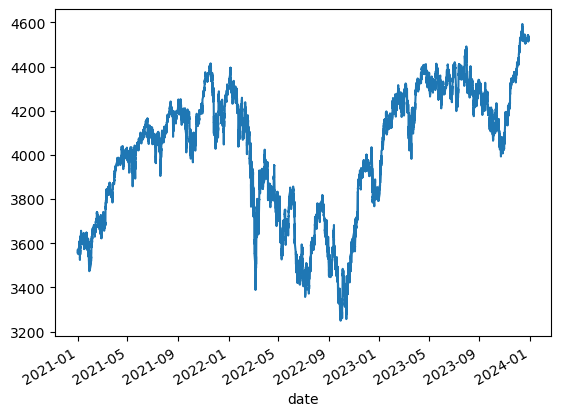

In [1]:
import pandas as pd
import numpy as np
import os

def preprocess_data(folder, start_time="10:00:00", end_time="19:00:00"):
    all_data = []
    for file in os.listdir(folder):
        data = pd.read_excel(folder + file,  engine='openpyxl')
        data = data.loc[data["Time Interval"]!= "Summary"]

        data["date"] = np.nan

        data["date"] = data.loc[~data["Time Interval"].str.contains("-"), "Time Interval"]

        data["date"] = data.date.ffill()

        data = data.loc[data["Time Interval"].str.contains("-")]

        data["date"] = data["date"].str.split("_").str[0]

        data["date"] += " " + data["Time Interval"].str.split("-").str[1]

        data["date"] = pd.to_datetime(data["date"])

        data["date_day"] = pd.to_datetime(data.date).dt.strftime("%Y%m%d").astype(int)
        timestamp_counts = data.groupby("date_day")["Time Interval"].count()
        valid_days = timestamp_counts[timestamp_counts>400]
        data = data.loc[data.date_day.isin(valid_days.index)]
        all_data.append(data)

    all_data = pd.concat(all_data)
    all_data = all_data.drop_duplicates()
    all_data = all_data.sort_values(by="date").drop(columns=["Time Interval","Tick Count","date_day","Net Chg"])
    all_data = all_data.set_index("date",drop=False)
    all_data=all_data.between_time(start_time, end_time)
    all_data["is_overnight"] = False 
    all_data.loc[all_data.date-all_data.date.shift(1) > pd.Timedelta("8 hour"), "is_overnight"] = True
    all_data=all_data.drop(columns=["date"])
    return all_data

start_time="10:00:00"
end_time="19:00:00"

eurex_folder="eurexdata/"
eurex=preprocess_data(eurex_folder, start_time, end_time)
eurex.Close.plot()

<Axes: >

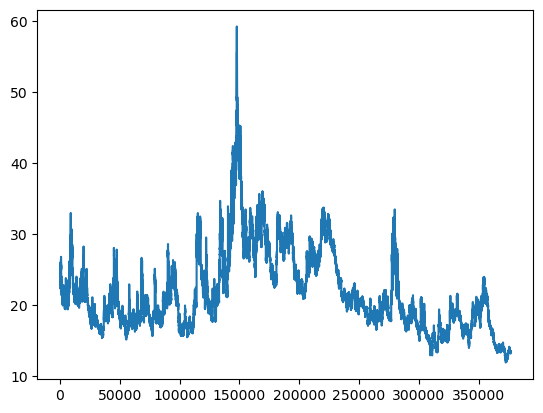

In [2]:
vix_folder="v2xdata/"
vix=preprocess_data(vix_folder,start_time, end_time)
vix.reset_index(drop=True).Close.plot()

<Axes: xlabel='date'>

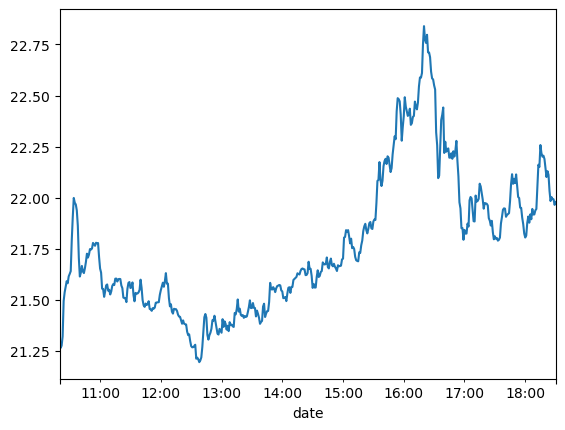

In [3]:

vix.loc[vix.index.normalize().unique()[5].strftime("%Y%m%d")].Close.plot()


In [4]:
vix['co_ret']=np.log(vix.Close/vix.Open)
vix['ho_ret']=np.log(vix.High/vix.Open)
vix['lo_ret']=np.log(vix.Low/vix.Open)
eurex['co_ret']=np.log(eurex.Close/eurex.Open)  
eurex['ho_ret']=np.log(eurex.High/eurex.Open)
eurex['lo_ret']=np.log(eurex.Low/eurex.Open)


<Axes: xlabel='time'>

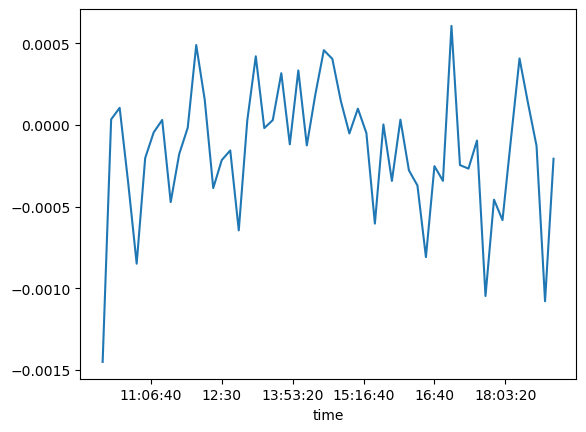

In [5]:
resample_period="10T"
vix_resampled=vix.resample(resample_period).agg({'Close':'last','High':'max','Low':'min','Open':'first',})
vix_resampled['co_ret']=np.log(vix_resampled.Close/vix_resampled.Open)
vix_resampled['ho_ret']=np.log(vix_resampled.High/vix_resampled.Open)
vix_resampled['lo_ret']=np.log(vix_resampled.Low/vix_resampled.Open)

vix_resampled.groupby(vix_resampled.index.time).co_ret.mean().plot()



<Axes: xlabel='date'>

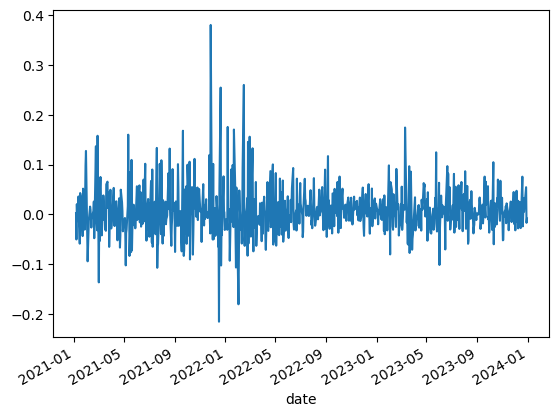

In [6]:
vix['oc_ret']=np.log(vix.Open/vix.Close.shift(1))
vix['cc_ret']=np.log(vix.Close/vix.Close.shift(1))
vix_on_ret=vix.loc[vix.is_overnight,"oc_ret"]
vix=vix.drop(columns=['is_overnight','oc_ret'])
vix_on_ret.plot()

<Axes: xlabel='date'>

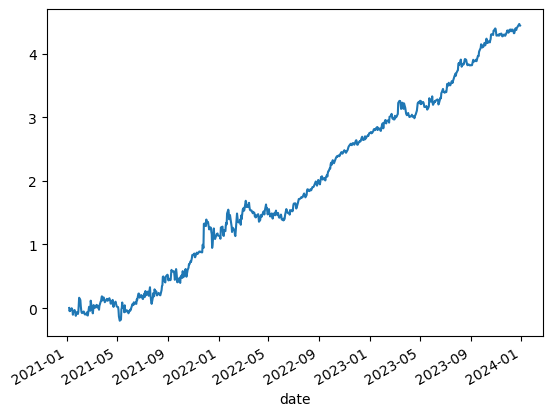

In [7]:
vix_on_ret.cumsum().plot()


<Axes: xlabel='time'>

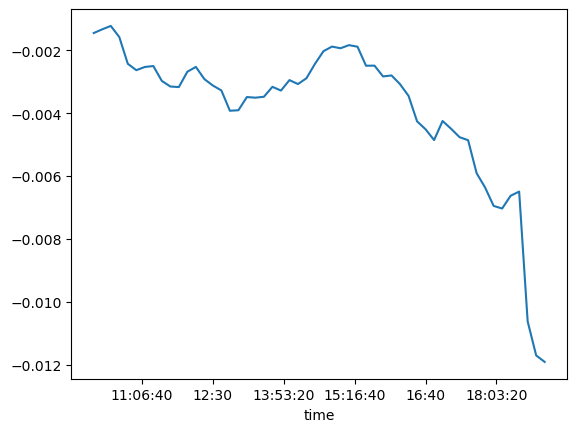

In [8]:
vix_resampled.groupby(vix_resampled.index.normalize()).co_ret.cumsum().groupby(vix_resampled.index.time).mean().plot()

<Axes: >

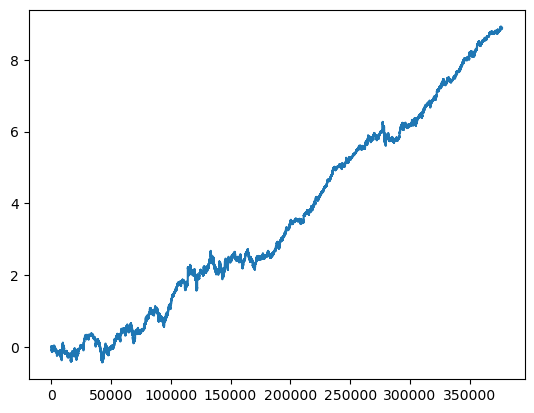

In [9]:
pd.Series(np.where(pd.Series(vix.index)-pd.Series(vix.index).shift()>=pd.Timedelta(8,unit='h'),np.log(vix.Open/vix.Close.shift()),-vix.co_ret)).cumsum().plot()

c:\Users\yusuf.bektas\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


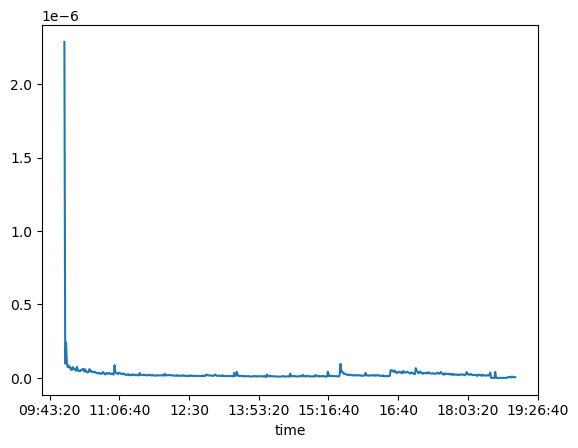

In [10]:
eurex['vol']=0.5*(np.log(eurex.High/eurex.Low)**2)-(2*np.log(2)-1)*(np.log(eurex.Close/eurex.Open)**2)
eurex['simple_vol']=np.log(eurex.Close/eurex.Open)**2
eurex['vol_ret']=(np.log(eurex.vol/eurex.vol.shift(1)))
eurex['vol'].groupby(eurex.index.time).mean().plot()
vix['vol']=0.5*(np.log(vix.High/vix.Low)**2)-(2*np.log(2)-1)*(np.log(vix.Close/vix.Open)**2)


<Axes: xlabel='date'>

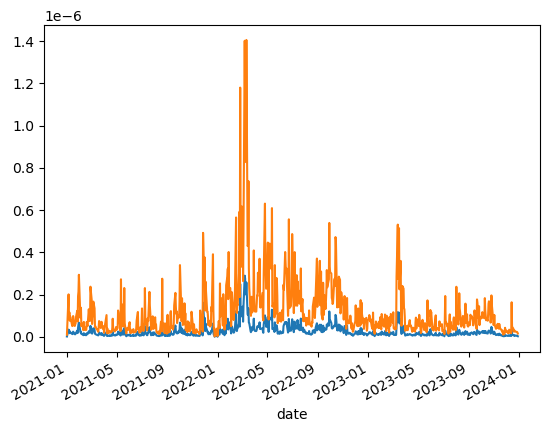

In [11]:
eurex['vol'].groupby(eurex.index.normalize()).mean().plot()
eurex.simple_vol.groupby(eurex.index.normalize()).mean().plot()

<Axes: xlabel='time'>

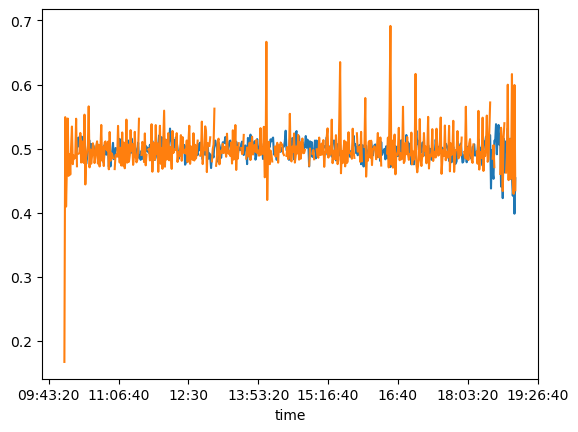

In [12]:
vix_coret_means=vix.cc_ret.groupby(vix.index.time).mean()/vix.cc_ret.groupby(vix.index.time).std()
eurex_vol_ret_means=eurex.vol_ret.groupby(eurex.index.time).mean()/eurex.vol_ret.groupby(eurex.index.time).std()
(1/(1+np.exp(-vix_coret_means))).plot()
(1/(1+np.exp(-eurex_vol_ret_means))).plot()

<Axes: xlabel='time'>

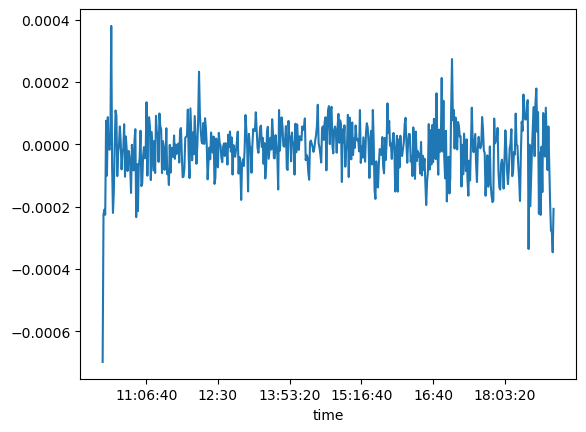

In [13]:
eurex=eurex.dropna()
vix=vix.dropna()
common_index=vix.index.intersection(eurex.index)
vix=vix.loc[common_index]
eurex=eurex.loc[common_index]

vix['co_ret'].groupby(vix.index.time).mean().plot()

<Axes: >

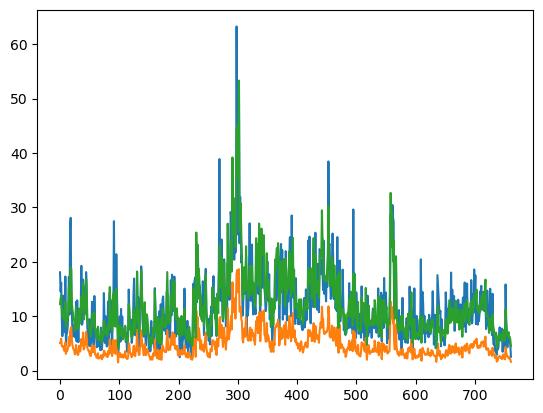

In [14]:
eurex_daily=eurex.resample('1D').agg({'Open':'first','High':'max','Low':'min','Close':'last','vol':'sum','simple_vol':'sum'}).rename(columns={'vol':'intraday_vol_sum','simple_vol':'intraday_simple_vol_sum'}).dropna()


day_multiplier=pd.Timedelta(8*60+50,unit="m")/(-pd.Timedelta(start_time,format='%hh:%mm')+pd.Timedelta(end_time,format='%hh:%mm'))
gk_multiplier=1.034
simple_multiplier=1.253

eurex_daily['rv_annualised_intraday']=np.sqrt(eurex_daily.intraday_vol_sum*252*day_multiplier)*gk_multiplier*100
eurex_daily['rv_annualised_eod']=0.5*(np.log(eurex_daily.High/eurex_daily.Low)**2)-(2*np.log(2)-1)*(np.log(eurex_daily.Close/eurex_daily.Open)**2)
eurex_daily['rv_annualised_eod']=np.sqrt(eurex_daily.rv_annualised_eod*252*day_multiplier)*gk_multiplier*100
eurex_daily['rv_annualised_simple_intraday']=np.sqrt(eurex_daily.intraday_simple_vol_sum*252*day_multiplier)*simple_multiplier*100
eurex_daily['rv_annualised_eod'].reset_index(drop=True).plot()
eurex_daily['rv_annualised_intraday'].reset_index(drop=True).plot()
eurex_daily['rv_annualised_simple_intraday'].reset_index(drop=True).plot()

<Axes: >

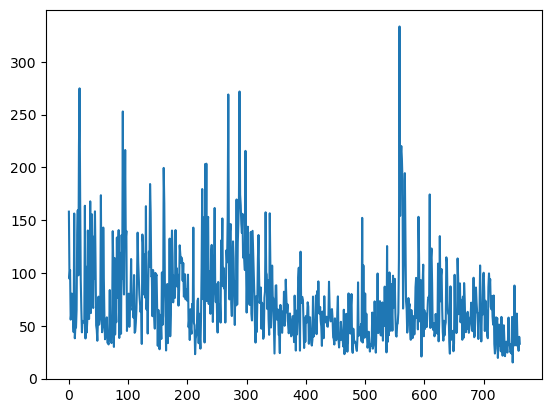

In [15]:
vix_daily=vix.resample('1D').agg({'Open':'first','High':'max','Low':'min','Close':'last'}).dropna()
vix_daily['rv_annualised']=0.5*(np.log(vix_daily.High/vix_daily.Low)**2)-(2*np.log(2)-1)*(np.log(vix_daily.Close/vix_daily.Open)**2)
vix_daily['rv_annualised']=np.sqrt(vix_daily.rv_annualised*252)*gk_multiplier*100
vix_daily['rv_annualised'].reset_index(drop=True).plot()


<Axes: >

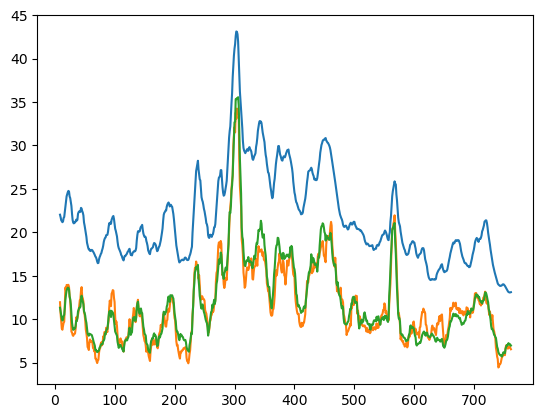

In [16]:
vix_daily.Close.rolling(10).mean().reset_index(drop=True).plot()
#(eurex_daily['rv_annualised_intraday']).reset_index(drop=True).plot()
(eurex_daily['rv_annualised_eod']).rolling(10).mean().reset_index(drop=True).plot()
(eurex_daily['rv_annualised_simple_intraday']).rolling(10).mean().reset_index(drop=True).plot()

<Axes: >

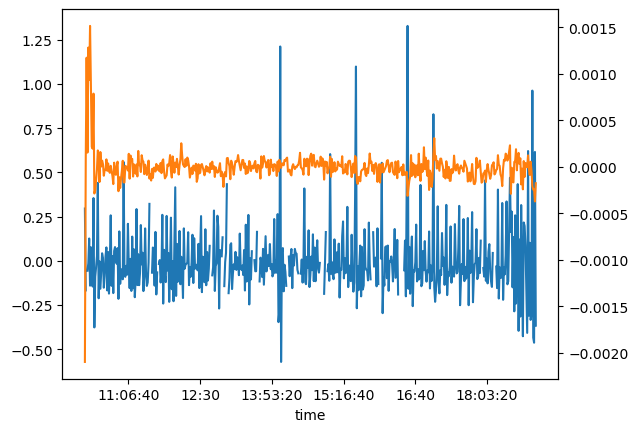

In [17]:
eurex.vol_ret.groupby(eurex.index.time).mean().plot()
vix.cc_ret.groupby(vix.index.time).mean().plot(secondary_y=True)    

In [18]:
pd.concat([vix.cc_ret,eurex.vol_ret],axis=1).corr() 

,cc_ret,vol_ret
cc_ret,1.00000,0.01142
vol_ret,0.01142,1.00000


In [19]:
eurex=eurex.replace([np.inf, -np.inf], np.nan).dropna()
vix=vix.replace([np.inf, -np.inf], np.nan).dropna()
common_index=vix.index.intersection(eurex.index)
vix=vix.loc[common_index]
eurex=eurex.loc[common_index]

In [20]:
import statsmodels.api as sm

ols=sm.OLS(vix.cc_ret,(eurex.vol_ret)).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 cc_ret   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              48.97
Date:                Fri, 14 Jun 2024   Prob (F-statistic):                    2.61e-12
Time:                        18:09:43   Log-Likelihood:                      1.6541e+06
No. Observations:              375382   AIC:                                 -3.308e+06
Df Residuals:                  375381   BIC:                                 -3.308e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
vol_ret     1.948e-05   2.78e-06      6.998      0.000     1.4e-05    2.49e-05
==============================================================================
Omnibus:                   733935.254   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      43234206677.850
Skew:                          14.311   Prob(JB):                         0.00
Kurtosis:                    1665.334   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
vix_outliers=vix.loc[(vix.cc_ret>vix.cc_ret.quantile(0.9999)) | (vix.cc_ret<vix.cc_ret.quantile(0.0001))]
eurex_outliers=eurex.loc[(eurex.vol_ret>eurex.vol_ret.quantile(0.9999)) | (eurex.vol_ret<eurex.vol_ret.quantile(0.0001))]
vix_outliers

,Close,Open,High,Low,Volume,co_ret,ho_ret,lo_ret,cc_ret,vol
date,,,,,,,,,,
2021-01-28 10:18:00,29.5597,29.5597,29.5597,29.5597,N.A.,0.000000,0.000000,0.000000,0.099138,0.000000e+00
2021-01-29 10:34:00,29.4426,29.4566,29.5015,29.4363,N.A.,-0.000475,0.001523,-0.000689,0.127092,2.360284e-06
2021-02-02 10:19:00,24.8859,24.8691,24.8859,24.8691,N.A.,0.000675,0.000675,0.000000,-0.093541,5.185458e-08
2021-02-22 10:22:00,23.4501,23.4924,23.4947,23.4501,N.A.,-0.001802,0.000098,-0.001802,0.135211,5.505362e-07
2021-02-26 10:18:00,25.8397,25.8805,25.8805,25.8397,N.A.,-0.001578,0.000000,-0.001578,0.156506,2.830363e-07
...,...,...,...,...,...,...,...,...,...,...
2023-06-15 10:16:00,13.2257,13.2592,13.2592,13.2257,N.A.,-0.002530,0.000000,-0.002530,-0.072895,7.276716e-07
2023-06-20 10:16:00,14.4162,14.4058,14.4162,14.3983,N.A.,0.000722,0.000722,-0.000521,0.097750,5.706308e-07
2023-10-09 10:20:00,20.7310,20.7090,20.7310,20.7090,N.A.,0.001062,0.001062,0.000000,0.105977,1.281882e-07


### Feature Engineering

In [22]:
s=pd.Series([1,2,3,4,6,7])
s.iloc[::-1].rolling(2).sum().iloc[::-1]

0     3.0
1     5.0
2     7.0
3    10.0
4    13.0
5     NaN
dtype: float64

In [23]:
pd.concat([np.exp(vix.co_ret.iloc[::-1].rolling(2).sum().iloc[::-1])*vix.Open,vix.Close.shift(-1)],axis=1).dropna().head(50)

,0,Close
date,,
2021-01-04 10:17:00,23.007955,22.9851
2021-01-04 10:18:00,22.958202,22.9595
2021-01-04 10:19:00,22.977023,22.9472
2021-01-04 10:20:00,22.950298,22.9669
2021-01-04 10:21:00,23.010702,23.0095
2021-01-04 10:22:00,22.957913,22.9637
2021-01-04 10:23:00,23.024871,23.0356
2021-01-04 10:24:00,23.060191,23.0683
2021-01-04 10:25:00,23.105399,23.1059


In [24]:
X=pd.concat([eurex.loc[~eurex.index.isin(eurex_outliers.index)].add_suffix("_eurex"),vix.loc[~vix.index.isin(vix_outliers.index)].add_suffix("_vix")],axis=1).dropna()

X['date_d']=X.index.date
last_n_days_mean=15
X[f'co_ret_vix_rollmean_{last_n_days_mean}_days']=X.groupby('date_d').co_ret_vix.rolling(last_n_days_mean).mean().reset_index(level=0,drop=True)
X[f"co_ret_eurex_rollmean_{last_n_days_mean}_days"]=X.groupby('date_d').co_ret_eurex.rolling(last_n_days_mean).mean().reset_index(level=0,drop=True)
X[f"vol_ret_eurex_rollmean_{last_n_days_mean}_days"]=X.groupby('date_d').vol_ret_eurex.rolling(last_n_days_mean).mean().reset_index(level=0,drop=True)
X[f'vol_eurex_rollmean_{last_n_days_mean}_days']=X.groupby('date_d').vol_eurex.rolling(last_n_days_mean).mean().reset_index(level=0,drop=True)
X[f'vol_vix_rollmean_{last_n_days_mean}_days']=X.groupby('date_d').vol_vix.rolling(last_n_days_mean).mean().reset_index(level=0,drop=True)

X[f'Close_eurex_diff_from_roll_mean{last_n_days_mean}_days']=X.Close_eurex-X.groupby('date_d').Close_eurex.rolling(last_n_days_mean).mean().reset_index(level=0,drop=True)
X[f'Close_vix_diff_from_roll_mean{last_n_days_mean}_days']=X.Close_vix-X.groupby('date_d').Close_vix.rolling(last_n_days_mean).mean().reset_index(level=0,drop=True)
X[f'vol_eurex_diff_from_roll_mean{last_n_days_mean}_days']=X.vol_eurex-X.groupby('date_d').vol_eurex.rolling(last_n_days_mean).mean().reset_index(level=0,drop=True)
X[f'vol_vix_diff_from_roll_mean{last_n_days_mean}_days']=X.vol_vix-X.groupby('date_d').vol_vix.rolling(last_n_days_mean).mean().reset_index(level=0,drop=True)


last_n_bars=[3,7,15,30]

for last_n_bar in last_n_bars:
    X[f'Close_eurex_diff_from_mean{last_n_bar}_bars']=X.Close_eurex-X.Close_eurex.rolling(last_n_bar).mean()
    X[f'Close_vix_diff_from_mean{last_n_bar}_bars']=X.Close_vix-X.Close_vix.rolling(last_n_bar).mean()
    X[f'vol_eurex_diff_from_mean{last_n_bar}_bars']=X.vol_eurex-X.vol_eurex.rolling(last_n_bar).mean()
    X[f'vol_vix_diff_from_mean{last_n_bar}_bars']=X.vol_vix-X.vol_vix.rolling(last_n_bar).mean()


last_day_diff=1

X['log_Close_eurex']=np.log(X.Close_eurex)
X['log_Close_vix']=np.log(X.Close_vix)
X['log_vol_eurex']=np.log(X.vol_eurex)
X['log_vol_vix']=np.log(X.vol_vix)

X[f"Close_eurex_diff{last_day_diff}"]=X.groupby(X.index.normalize()).log_Close_eurex.diff(last_day_diff)
X[f"Close_vix_diff{last_day_diff}"]=X.groupby(X.index.normalize()).log_Close_vix.diff(last_day_diff)
X[f"vol_eurex_diff{last_day_diff}"]=X.groupby(X.index.normalize()).log_vol_eurex.diff(last_day_diff)
X[f"vol_vix_diff{last_day_diff}"]=X.groupby(X.index.normalize()).log_vol_vix.diff(last_day_diff)


prediction_horizon=10

y=X.co_ret_vix.iloc[::-1].rolling(prediction_horizon).sum().iloc[::-1]
y_actual_val=X.Close_vix.shift(-prediction_horizon+1)
X=X.shift().dropna()

common_index=X.index.intersection(y.index)
X=X.loc[common_index]
y=y.loc[common_index]


X=X.drop(
    columns=['Close_eurex', 'Open_eurex', 'High_eurex', 'Low_eurex', 'Volume_eurex',
       'is_overnight_eurex', "date_d","cc_ret_vix",
       'vol_eurex', 'simple_vol_eurex', 'vol_ret_eurex', 'Close_vix',
       'Open_vix', 'High_vix', 'Low_vix', 'Volume_vix', 'vol_vix',"log_Close_eurex","log_Close_vix","log_vol_eurex","log_vol_vix"]
)

model_start_time="10:15:00"
model_end_time="18:30:00"
X=X.between_time(model_start_time, model_end_time)
y=y.loc[X.index]
y_actual_val=y_actual_val.loc[X.index]
X.info()


c:\Users\yusuf.bektas\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 363256 entries, 2021-01-04 10:47:00 to 2023-12-29 18:30:00
Data columns (total 35 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   co_ret_eurex                            363256 non-null  float64
 1   ho_ret_eurex                            363256 non-null  float64
 2   lo_ret_eurex                            363256 non-null  float64
 3   co_ret_vix                              363256 non-null  float64
 4   ho_ret_vix                              363256 non-null  float64
 5   lo_ret_vix                              363256 non-null  float64
 6   co_ret_vix_rollmean_15_days             363256 non-null  float64
 7   co_ret_eurex_rollmean_15_days           363256 non-null  float64
 8   vol_ret_eurex_rollmean_15_days          363256 non-null  float64
 9   vol_eurex_rollmean_15_days              363256 non-null  float64
 10  vol_vix_ro

<Axes: >

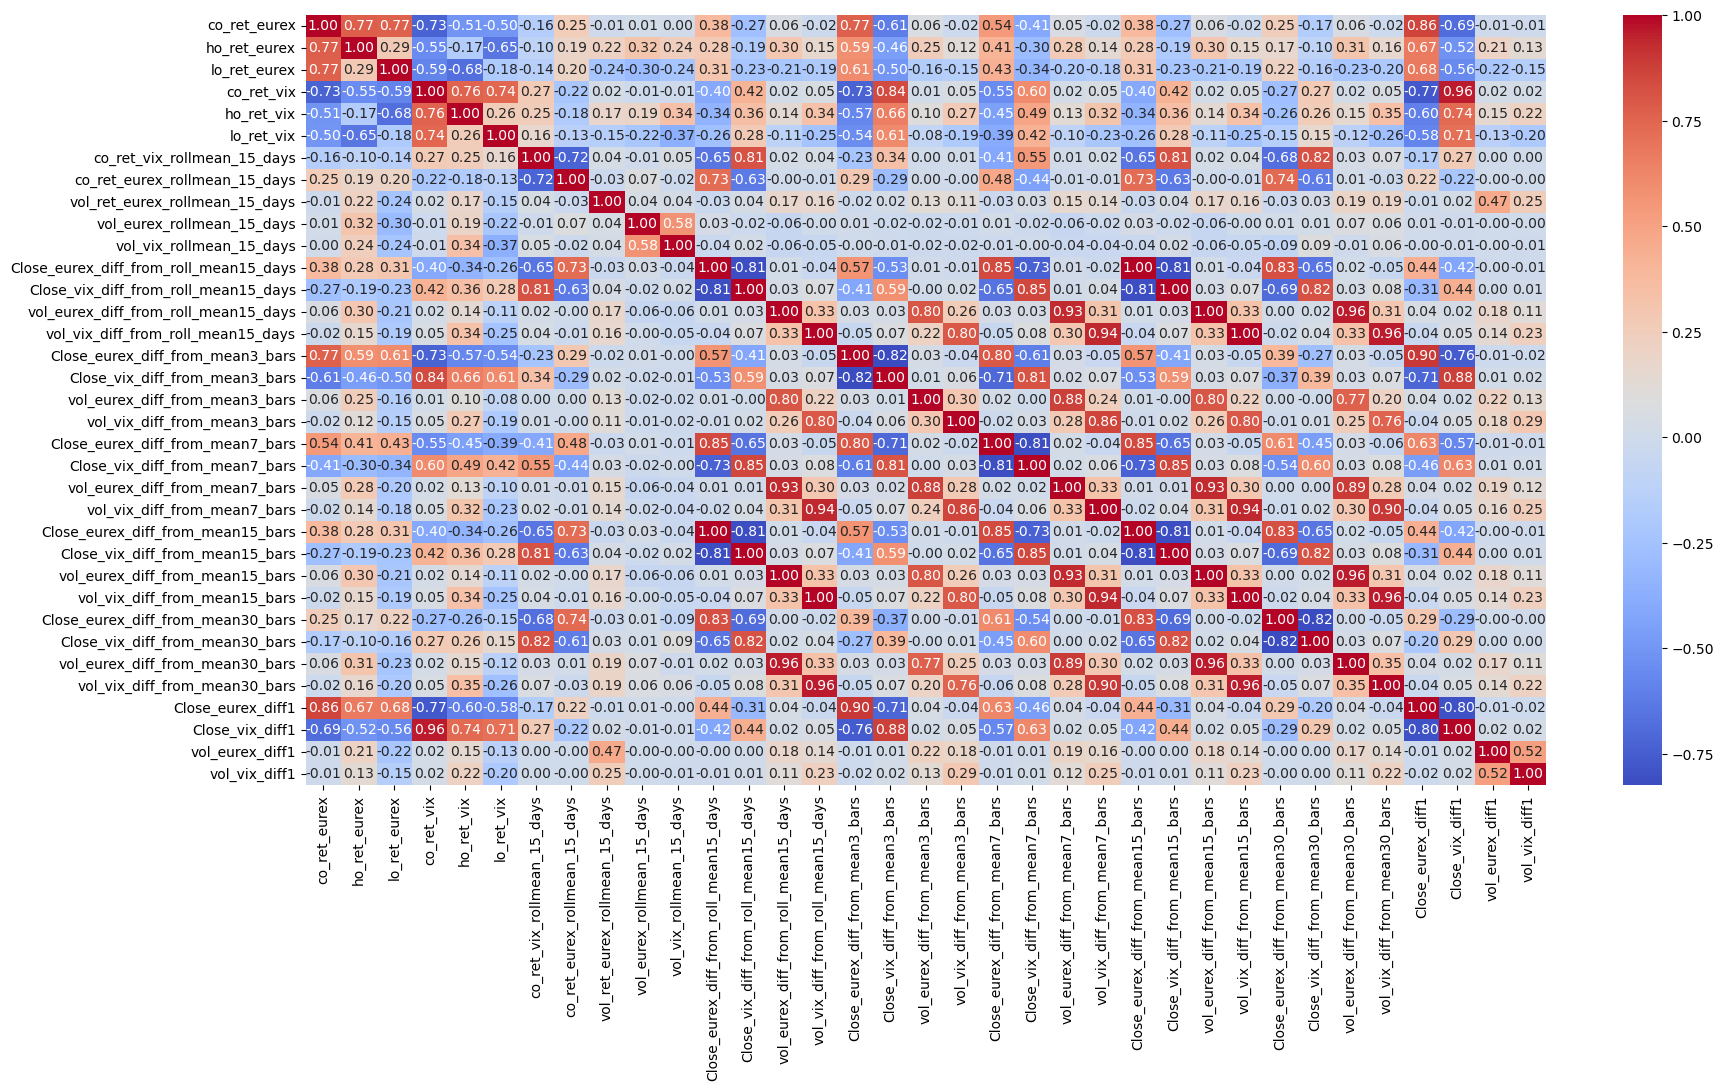

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sns.heatmap(X.corr(),annot=True,fmt=".2f",cmap='coolwarm')


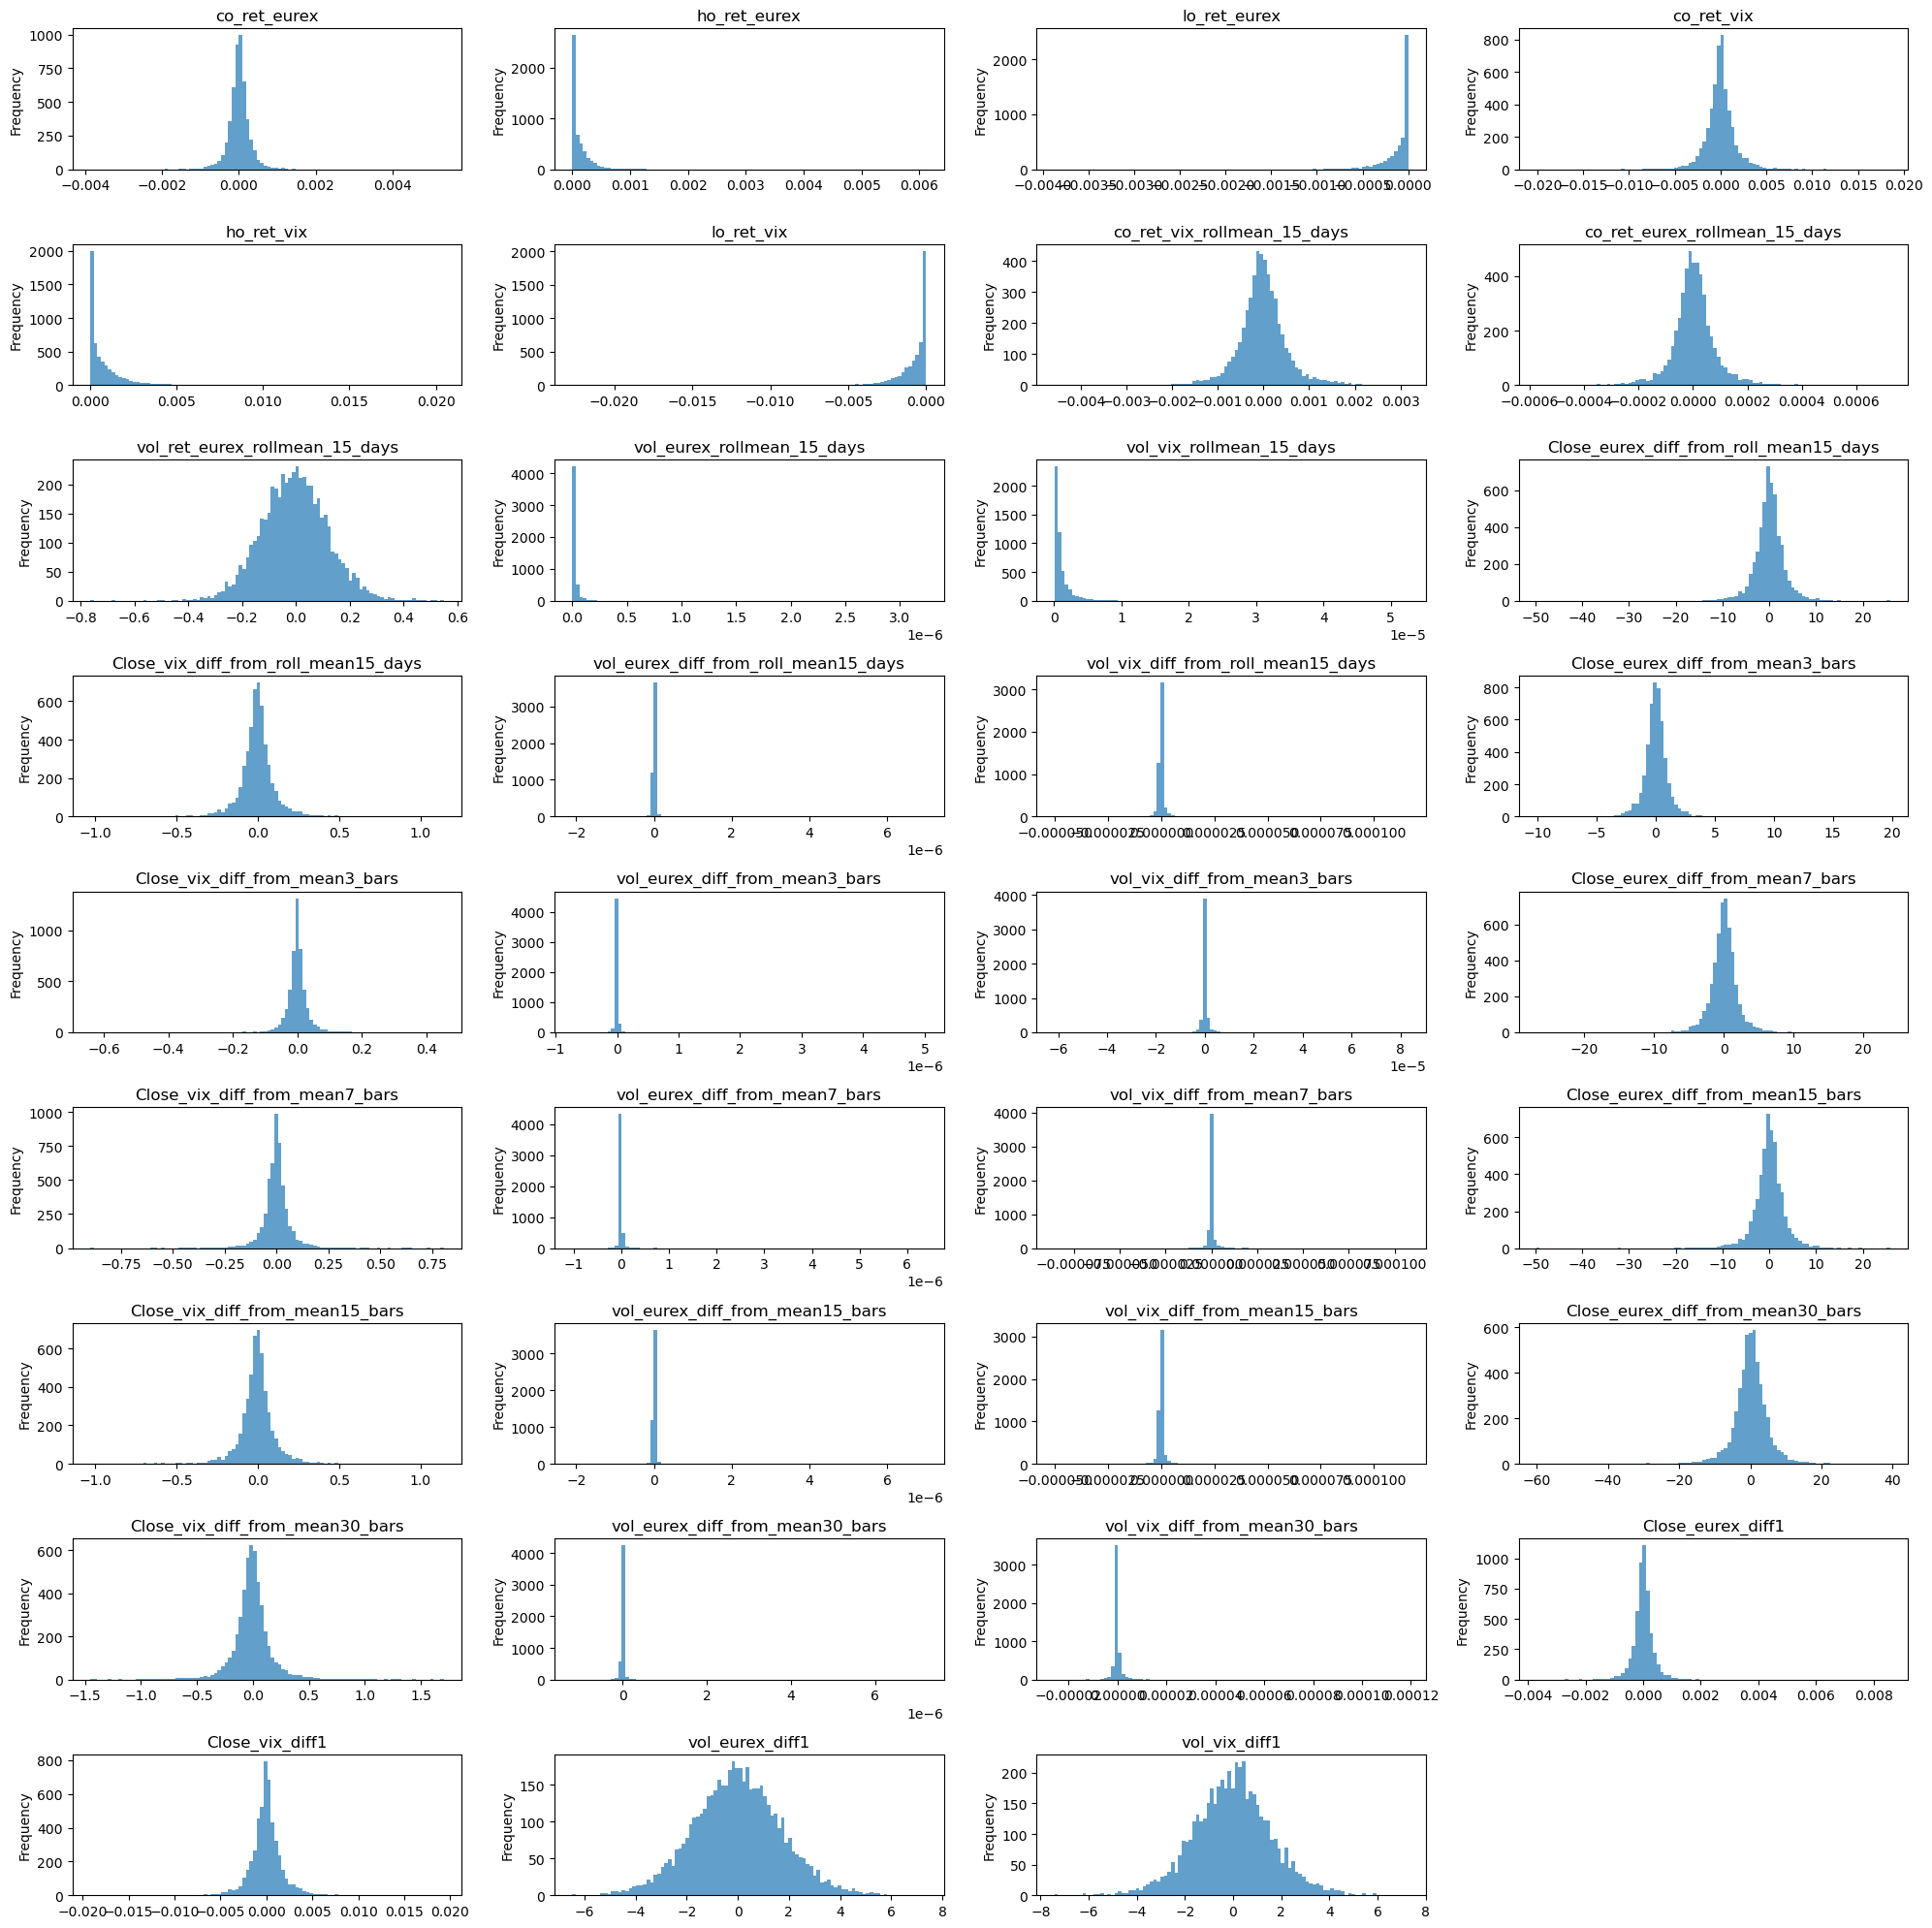

In [26]:
# Determine the number of rows and columns for the subplots
sample=X.sample(5000)
num_features = X.shape[1]
num_cols = 4
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(X.columns):
    ax = axes[i]
    sample[feature].plot(kind='hist', bins=100, ax=ax, alpha=0.7)
    ax.set_title(feature)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [27]:
### Train Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Regression

In [28]:
import statsmodels.api as sm

ols=sm.OLS(y_train,X_train).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             co_ret_vix   R-squared (uncentered):                   0.012
Model:                            OLS   Adj. R-squared (uncentered):              0.012
Method:                 Least Squares   F-statistic:                              113.9
Date:                Fri, 14 Jun 2024   Prob (F-statistic):                        0.00
Time:                        18:10:04   Log-Likelihood:                      1.0234e+06
No. Observations:              290604   AIC:                                 -2.047e+06
Df Residuals:                  290572   BIC:                                 -2.046e+06
Df Model:                          32                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
co_ret_eurex                              -0.0382      0.220     -0.173      0.862      -0.470       0.393
ho_ret_eurex                               0.3295      0.200      1.651      0.099      -0.062       0.721
lo_ret_eurex                               0.3094      0.202      1.531      0.126      -0.087       0.706
co_ret_vix                                 0.4383      0.043     10.266      0.000       0.355       0.522
ho_ret_vix                                -0.1452      0.032     -4.558      0.000      -0.208      -0.083
lo_ret_vix                                -0.2592      0.031     -8.295      0.000      -0.320      -0.198
co_ret_vix_rollmean_15_days                0.2380      0.055      4.303      0.000       0.130       0.346
co_ret_eurex_rollmean_15_days             -0.6631      0.299     -2.221      0.026      -1.248      -0.078
vol_ret_eurex_rollmean_15_days             0.0006      0.000      4.916      0.000       0.000       0.001
vol_eurex_rollmean_15_days             -4740.7904    448.881    -10.561      0.000   -5620.585   -3860.995
vol_vix_rollmean_15_days                 -64.6048     12.901     -5.008      0.000     -89.891     -39.319
Close_eurex_diff_from_roll_mean15_days  4.354e+07   4.08e+07      1.066      0.286   -3.65e+07    1.24e+08
Close_vix_diff_from_roll_mean15_days    -483.1691    453.215     -1.066      0.286   -1371.457     405.119
vol_eurex_diff_from_roll_mean15_days   -3120.2065    451.017     -6.918      0.000   -4004.186   -2236.227
vol_vix_diff_from_roll_mean15_days        12.6885     24.259      0.523      0.601     -34.859      60.235
Close_eurex_diff_from_mean3_bars       -6.751e-05   5.78e-05     -1.168      0.243      -0.000    4.58e-05
Close_vix_diff_from_mean3_bars             0.0042      0.002      2.715      0.007       0.001       0.007
vol_eurex_diff_from_mean3_bars          1158.5996    420.432      2.756      0.006     334.564    1982.635
vol_vix_diff_from_mean3_bars               3.0705     12.033      0.255      0.799     -20.514      26.655
Close_eurex_diff_from_mean7_bars           0.0002   3.43e-05      5.227      0.000       0.000       0.000
Close_vix_diff_from_mean7_bars             0.0095      0.001     10.191      0.000       0.008       0.011
vol_eurex_diff_from_mean7_bars          3454.3406    604.488      5.714      0.000    2269.561    4639.120
vol_vix_diff_from_mean7_bars              27.1758     17.791      1.527      0.127      -7.695      62.046
Close_eurex_diff_from_mean15_bars      -4.354e+07   4.08e+07     -1.066      0.286   -1.24e+08    3.65e+07
Close_vix_diff_from_mean15_bars          483.1665    453.215      1.066      0.286    -405.122 

In [29]:
ols_train_error=(y_train-ols.predict(X_train))
ma_X_train=pd.concat([X_train,ols_train_error.shift(prediction_horizon)],axis=1).dropna()
ols_ma=sm.OLS(y_train.loc[ma_X_train.index],ma_X_train).fit()
ols_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             co_ret_vix   R-squared (uncentered):                   0.012
Model:                            OLS   Adj. R-squared (uncentered):              0.012
Method:                 Least Squares   F-statistic:                              111.0
Date:                Fri, 14 Jun 2024   Prob (F-statistic):                        0.00
Time:                        18:10:07   Log-Likelihood:                      1.0234e+06
No. Observations:              290594   AIC:                                 -2.047e+06
Df Residuals:                  290561   BIC:                                 -2.046e+06
Df Model:                          33                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
co_ret_eurex                              -0.0312      0.220     -0.142      0.887      -0.463       0.400
ho_ret_eurex                               0.3333      0.200      1.670      0.095      -0.058       0.725
lo_ret_eurex                               0.3120      0.202      1.544      0.123      -0.084       0.708
co_ret_vix                                 0.4252      0.043      9.931      0.000       0.341       0.509
ho_ret_vix                                -0.1445      0.032     -4.534      0.000      -0.207      -0.082
lo_ret_vix                                -0.2603      0.031     -8.330      0.000      -0.322      -0.199
co_ret_vix_rollmean_15_days                0.1908      0.056      3.380      0.001       0.080       0.301
co_ret_eurex_rollmean_15_days             -0.8034      0.301     -2.674      0.008      -1.392      -0.214
vol_ret_eurex_rollmean_15_days             0.0006      0.000      4.893      0.000       0.000       0.001
vol_eurex_rollmean_15_days             -4804.9948    449.137    -10.698      0.000   -5685.290   -3924.699
vol_vix_rollmean_15_days                 -66.0974     12.906     -5.121      0.000     -91.394     -40.801
Close_eurex_diff_from_roll_mean15_days  4.331e+07   4.08e+07      1.060      0.289   -3.67e+07    1.23e+08
Close_vix_diff_from_roll_mean15_days    -520.0593    490.416     -1.060      0.289   -1481.261     441.142
vol_eurex_diff_from_roll_mean15_days   -3148.6301    451.136     -6.979      0.000   -4032.845   -2264.415
vol_vix_diff_from_roll_mean15_days       -64.0224     52.495     -1.220      0.223    -166.912      38.867
Close_eurex_diff_from_mean3_bars       -4.784e-05    5.8e-05     -0.825      0.409      -0.000    6.58e-05
Close_vix_diff_from_mean3_bars             0.0049      0.002      3.152      0.002       0.002       0.008
vol_eurex_diff_from_mean3_bars          1165.3331    420.431      2.772      0.006     341.300    1989.366
vol_vix_diff_from_mean3_bars               3.1047     12.033      0.258      0.796     -20.479      26.688
Close_eurex_diff_from_mean7_bars           0.0002   3.45e-05      4.814      0.000    9.83e-05       0.000
Close_vix_diff_from_mean7_bars             0.0095      0.001     10.132      0.000       0.008       0.011
vol_eurex_diff_from_mean7_bars          3377.7232    604.765      5.585      0.000    2192.401    4563.045
vol_vix_diff_from_mean7_bars              27.9204     17.792      1.569      0.117      -6.951      62.792
Close_eurex_diff_from_mean15_bars      -4.331e+07   4.08e+07     -1.060      0.289   -1.23e+08    3.67e+07
Close_vix_diff_from_mean15_bars          520.0560    490.416      1.060      0.289    -441.145 

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

y_test_ols=ols.predict(X_test)
ols_test_error=(y_test-ols.predict(X_test)).shift().dropna()
X_test_ols_ma=pd.concat([X_test,ols_test_error.shift(prediction_horizon)],axis=1).dropna()
y_test_ols_ma=ols_ma.predict(X_test_ols_ma)
print(f"OLS Test MSE: {mean_squared_error(y_test,y_test_ols)}")
print(f"OLS Test R2: {r2_score(y_test,y_test_ols)}")
print(f"OLS MA Test MSE: {mean_squared_error(y_test.loc[X_test_ols_ma.index],y_test_ols_ma)}")
print(f"OLS MA Test R2: {r2_score(y_test.loc[X_test_ols_ma.index],y_test_ols_ma)}")



OLS Test MSE: 2.157927863200695e-05
OLS Test R2: 0.007465476068350463
OLS MA Test MSE: 2.157875094764529e-05
OLS MA Test R2: 0.007603530403654135


<Axes: >

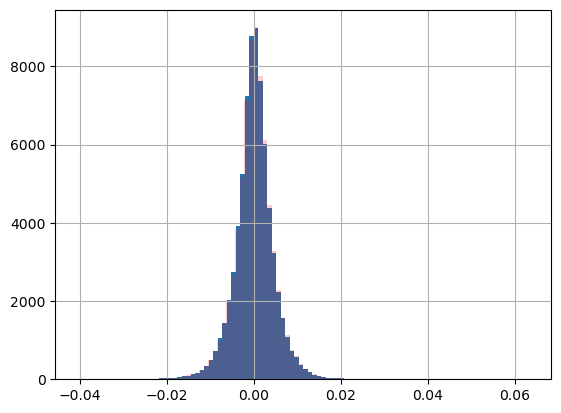

In [31]:
ols_test_errors=y_test_ols-y_test
ols_ma_test_errors=y_test_ols_ma-y_test.loc[X_test_ols_ma.index]
ols_test_errors.hist(bins=100)
ols_ma_test_errors.hist(bins=100,alpha=0.2,color='red')

In [32]:
print(f"OLS Test Errors autocorrelation: {ols_test_errors.autocorr()}") 
print(f"OLS MA Test Errors autocorrelation: {ols_ma_test_errors.autocorr()}")

OLS Test Errors autocorrelation: 0.9105782817404348
OLS MA Test Errors autocorrelation: 0.9118556782596605


<Axes: xlabel='date'>

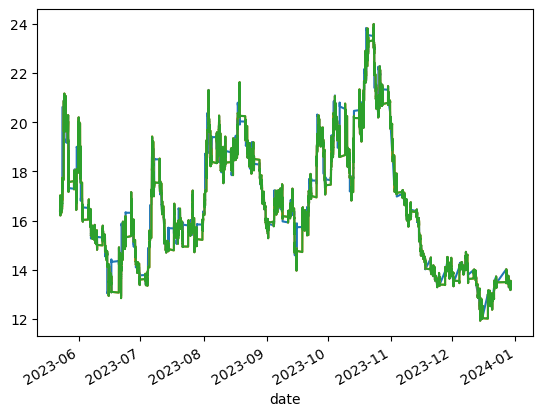

In [33]:
y_test_actual_val=y_actual_val.loc[X_test.index]
y_test_actual_val_ols=np.exp(y_test_ols)*y_test_actual_val.shift(prediction_horizon)
y_test_actual_val_ols_ma=np.exp(y_test_ols_ma)*y_test_actual_val.shift(prediction_horizon)
y_test_actual_val.plot()
y_test_actual_val_ols.plot()
y_test_actual_val_ols_ma.plot()

In [34]:
y_test_actual_val_ols

date
2023-05-22 13:59:00          NaN
2023-05-22 14:00:00          NaN
2023-05-22 14:01:00          NaN
2023-05-22 14:02:00          NaN
2023-05-22 14:03:00          NaN
                         ...    
2023-12-29 18:26:00    13.466149
2023-12-29 18:27:00    13.458661
2023-12-29 18:28:00    13.455998
2023-12-29 18:29:00    13.465205
2023-12-29 18:30:00    13.463006
Length: 72652, dtype: float64

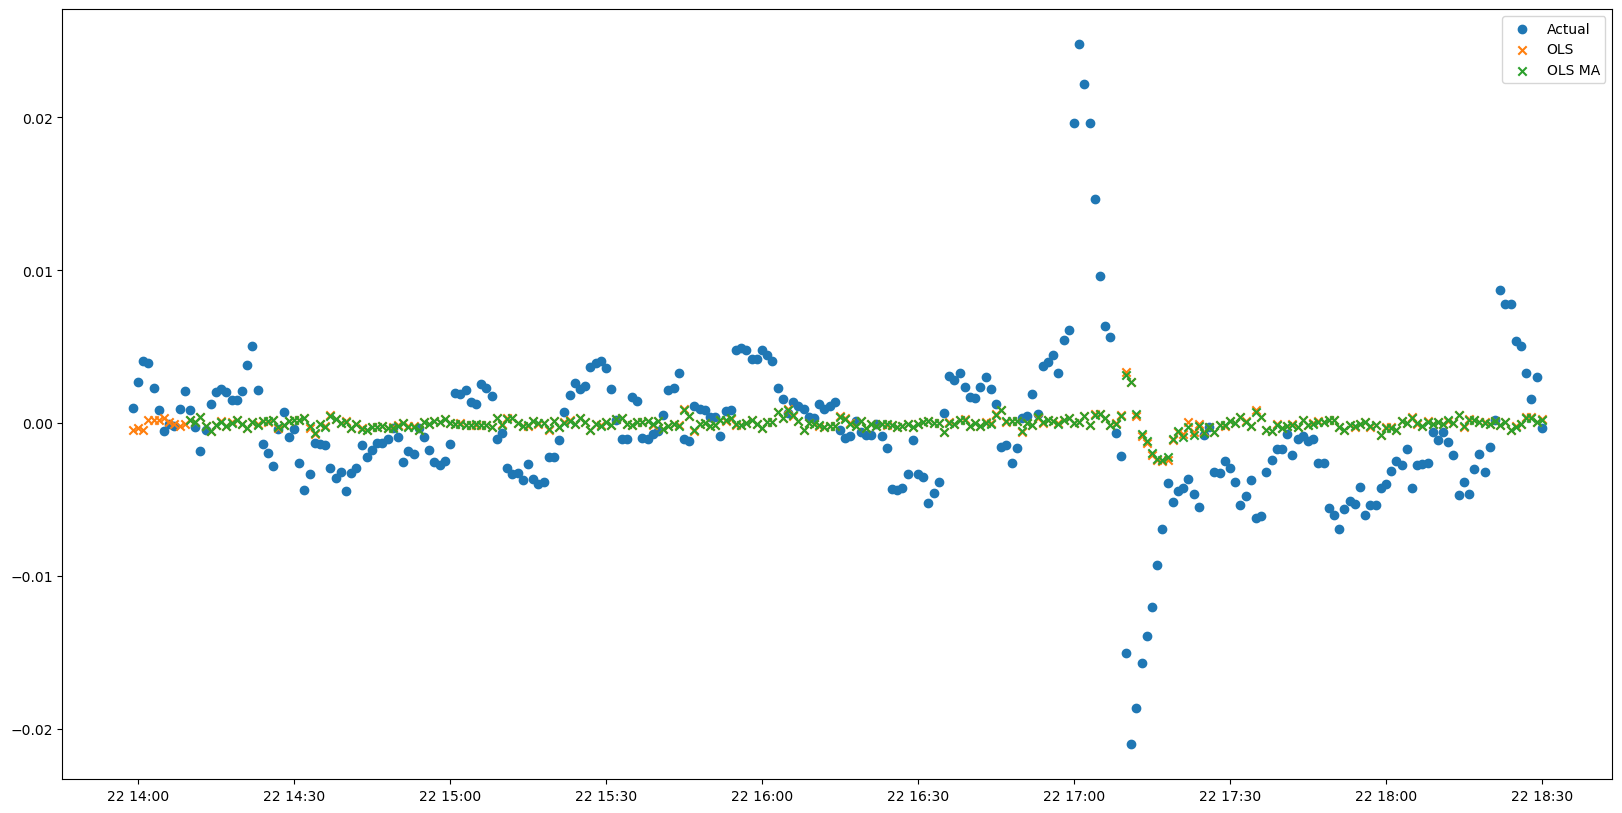

In [35]:
import matplotlib.pyplot as plt

day = "2023-05-22"

fig, ax = plt.subplots(figsize=(20, 10))

# Plotting the points
ax.scatter(y_test.loc[day].index, y_test.loc[day], label="Actual", marker='o')
ax.scatter(y_test_ols.loc[day].index, y_test_ols.loc[day], label="OLS", marker='x')
ax.scatter(y_test_ols_ma.loc[day].index, y_test_ols_ma.loc[day], label="OLS MA", marker='x')

ax.legend()

plt.show()


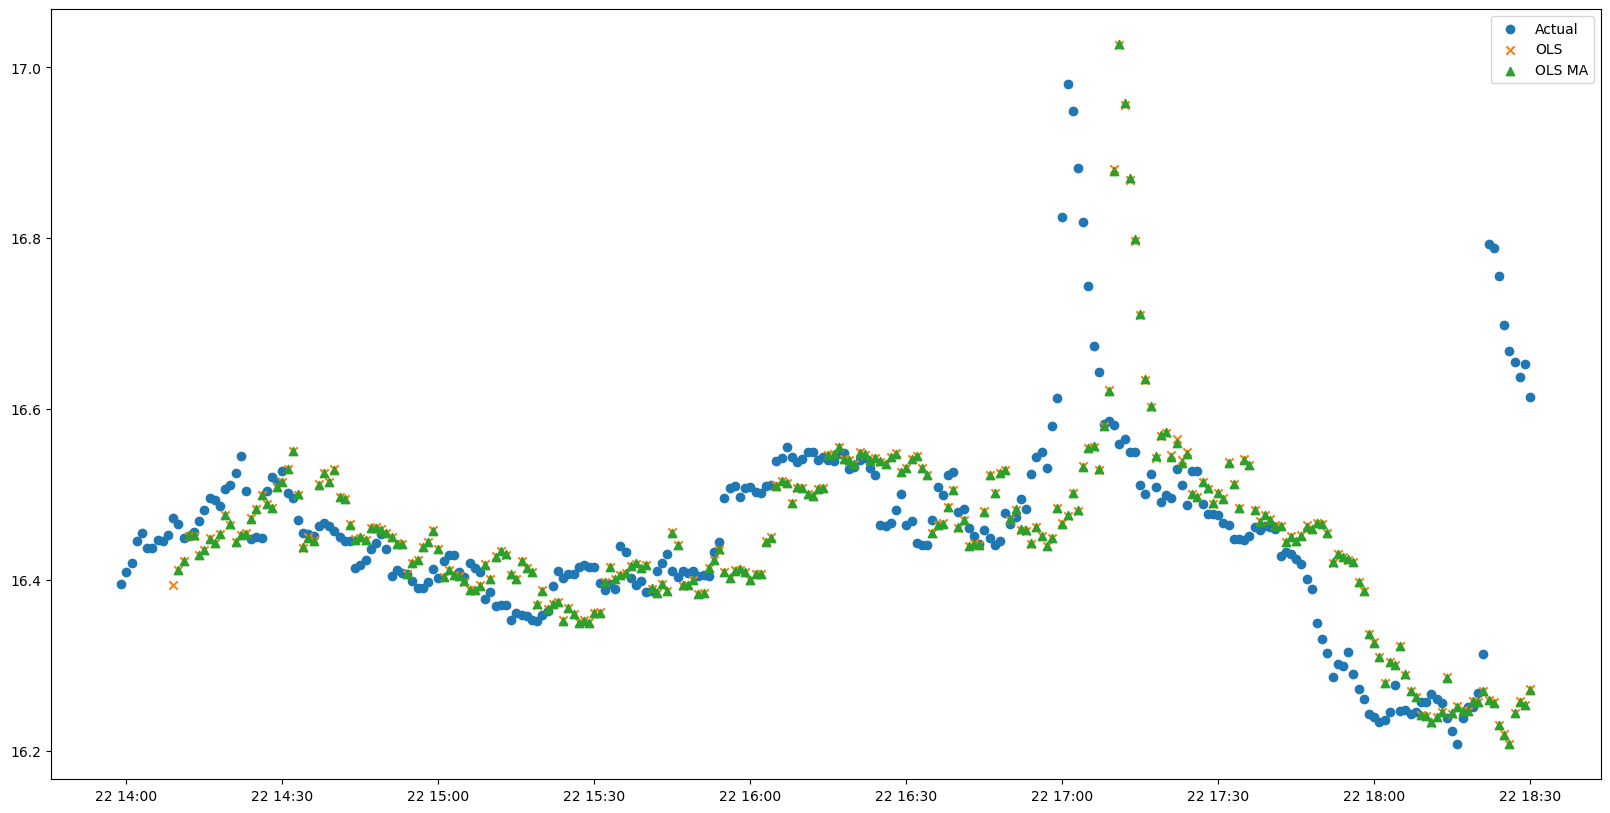

In [36]:
import matplotlib.pyplot as plt

day = "2023-05-22"

fig, ax = plt.subplots(figsize=(20, 10))

# Plotting the points
ax.scatter(y_test_actual_val.loc[day].index, y_test_actual_val.loc[day], label="Actual", marker='o')
ax.scatter(y_test_actual_val_ols.loc[day].index, y_test_actual_val_ols.loc[day], label="OLS", marker='x')
ax.scatter(y_test_actual_val_ols_ma.loc[day].index, y_test_actual_val_ols_ma.loc[day], label="OLS MA", marker='^')

ax.legend()

plt.show()


### Confusion Matrix

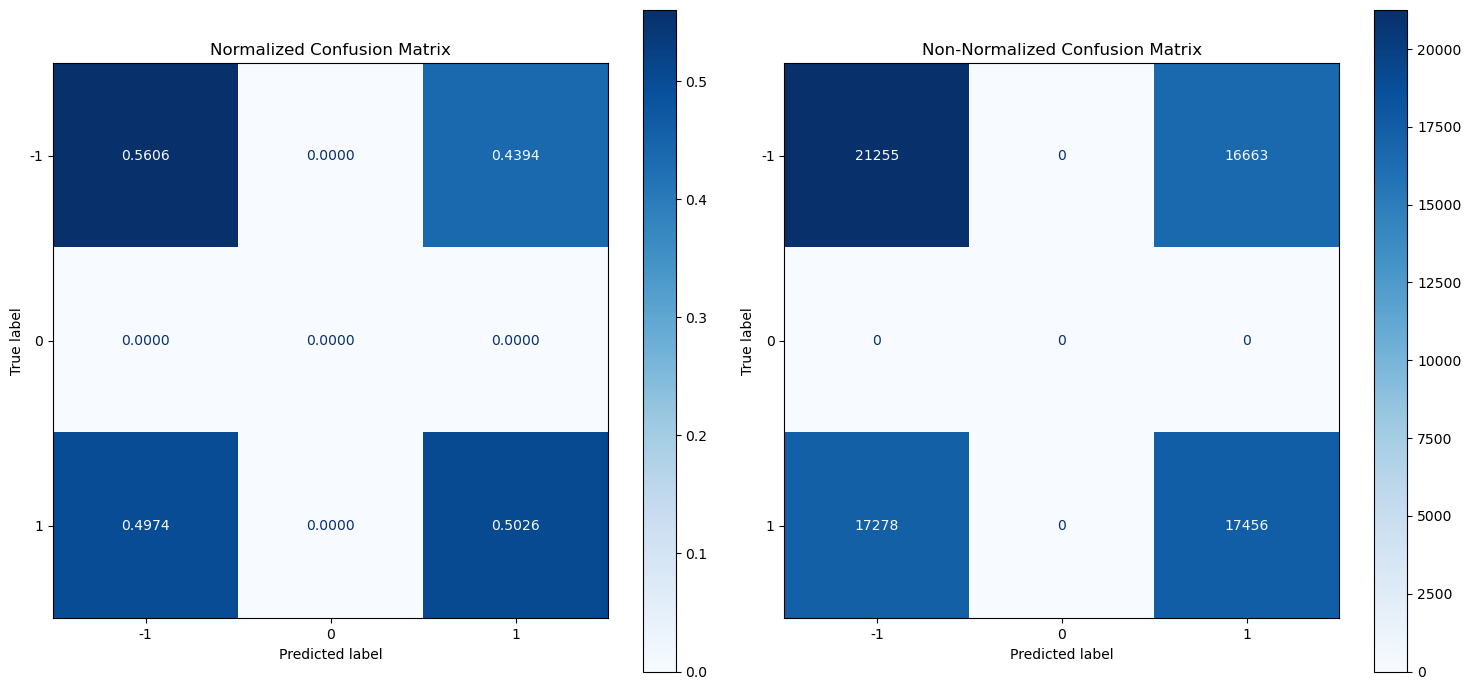

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_ols_binary=np.where(y_test_ols>0,1,np.where(y_test_ols<0,-1,0))
#y_test_ols_ma_binary=np.where(y_test_ols_ma>0,1,np.where(y_test_ols_ma<0,-1,0))
y_test_binary=np.where(y_test>0,1,np.where(y_test<0,-1,0))

# Compute confusion matrices
cm_normalized = confusion_matrix(y_test_binary, y_test_ols_binary, labels=[-1, 0, 1], normalize='true')
cm_non_normalized = confusion_matrix(y_test_binary, y_test_ols_binary, labels=[-1, 0, 1])

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Plot normalized confusion matrix
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[-1, 0, 1])
disp_normalized.plot(ax=ax[0], cmap=plt.cm.Blues, values_format='0.4f')
ax[0].set_title('Normalized Confusion Matrix')

# Plot non-normalized confusion matrix
disp_non_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_non_normalized, display_labels=[-1, 0, 1])
disp_non_normalized.plot(ax=ax[1], cmap=plt.cm.Blues, values_format='d')
ax[1].set_title('Non-Normalized Confusion Matrix')

plt.tight_layout()
plt.show()


In [38]:
from sklearn.metrics import classification_report

print(classification_report(y_test_binary, y_test_ols_binary, labels=[-1, 1]))

              precision    recall  f1-score   support

          -1       0.55      0.56      0.56     37918
           1       0.51      0.50      0.51     34734

    accuracy                           0.53     72652
   macro avg       0.53      0.53      0.53     72652
weighted avg       0.53      0.53      0.53     72652



### Classification

In [75]:
qtl=0.33
y_class=np.where(y<y.quantile(qtl),-1,np.where(y>y.quantile(1-qtl),1,0))
y_class=pd.Series(y_class,index=y.index)
X['hour'] = X.index.hour
X['day_of_week'] = X.index.dayofweek

hour_dummies = pd.get_dummies(X['hour'], prefix='hour')

day_of_week_dummies = pd.get_dummies(X['day_of_week'], prefix='day_of_week')

# Drop the original columns and concatenate the new one-hot encoded columns
X = X.drop(['hour', 'day_of_week'], axis=1)
X = pd.concat([X, hour_dummies, day_of_week_dummies], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, shuffle=False)


In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'penalty': ['l2','l1'],
    'C': [10**(-2),10**(-1),10**1, 10**2, 10**3, 10**4, 10**5],
    'solver': ['lbfgs'],
    'max_iter': [500],
    'multi_class': ['multinomial']
}


log_reg = LogisticRegression()

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_pred_prob = best_model.predict_proba(X_test_scaled)


print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

print("Model coefficients:")
print(best_model.coef_)
print("Intercept:")
print(best_model.intercept_)

c:\Users\yusuf.bektas\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\yusuf.bektas\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\yusuf.bektas\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yusuf.bektas\AppData\Local\anaconda3\Li

Best Parameters: {'C': 100, 'max_iter': 500, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.43496305219764075
              precision    recall  f1-score   support

          -1       0.41      0.51      0.45     26993
           0       0.26      0.00      0.00     17795
           1       0.40      0.56      0.47     27864

    accuracy                           0.40     72652
   macro avg       0.36      0.36      0.31     72652
weighted avg       0.37      0.40      0.35     72652

[[13636    36 13321]
 [ 7210    33 10552]
 [12103    57 15704]]
Model coefficients:
[[ 6.21817286e-03 -2.30292721e-02  4.94738035e-03 -5.89955926e-02
   1.11541321e-01 -6.14036912e-02 -1.13501400e-02  9.29258748e-03
  -1.73263774e-02  2.97544698e-02  1.56881870e-01  9.02143326e-03
   1.66776779e-02  1.79294234e-02  1.30871011e-01 -1.52193687e-04
  -1.81265953e-02 -1.58917884e-02  1.54294121e-02 -4.87059642e-02
  -1.00251861e-01 -2.85755403e-02 -6.20604926

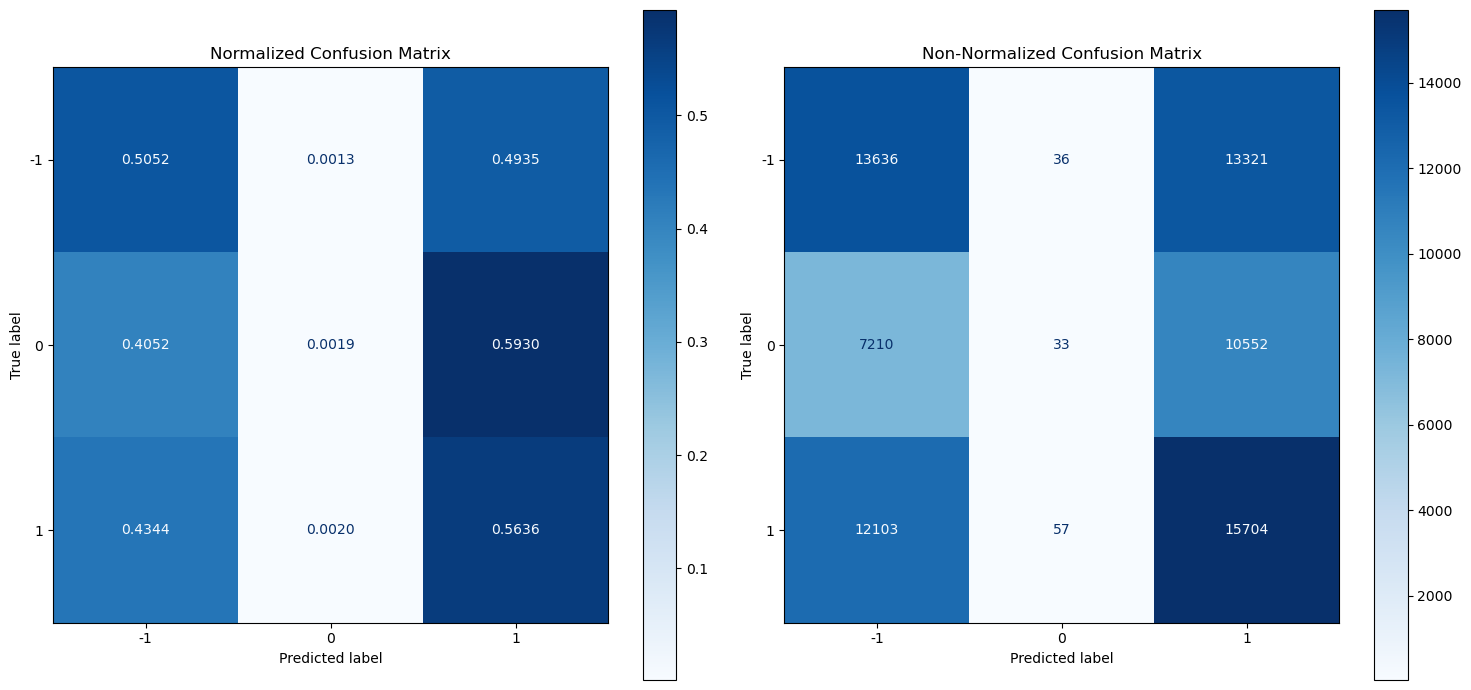

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrices
cm_normalized = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1], normalize='true')
cm_non_normalized = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Plot normalized confusion matrix
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[-1, 0, 1])
disp_normalized.plot(ax=ax[0], cmap=plt.cm.Blues, values_format='0.4f')
ax[0].set_title('Normalized Confusion Matrix')

# Plot non-normalized confusion matrix
disp_non_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_non_normalized, display_labels=[-1, 0, 1])
disp_non_normalized.plot(ax=ax[1], cmap=plt.cm.Blues, values_format='d')
ax[1].set_title('Non-Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

In [76]:
from sklearn.kernel_approximation import PolynomialCountSketch

# Apply Gaussian kernel transformation
transformed_feature = PolynomialCountSketch(degree=2, gamma=1, coef0=1,n_components=1000)
X_train_transformed = transformed_feature.fit_transform(X_train)
X_test_transformed = transformed_feature.transform(X_test)

# Standardize the features
scaler = StandardScaler()
X_train_rbf_scaled = scaler.fit_transform(X_train_transformed)
X_test_rbf_scaled = scaler.transform(X_test_transformed)

# Define the parameter grid
param_grid = {
    'penalty': ['l2','l1'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs'],
    'max_iter': [500],
    'multi_class': ['multinomial']
}

# Initialize the logistic regression model
log_reg = LogisticRegression()

# Initialize Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_rbf_scaled, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

# Use the best estimator to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_rbf_scaled)
y_pred_prob = best_model.predict_proba(X_test_rbf_scaled)

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

# Print the model coefficients
print("Model coefficients:")
print(best_model.coef_)
print("Intercept:")
print(best_model.intercept_)

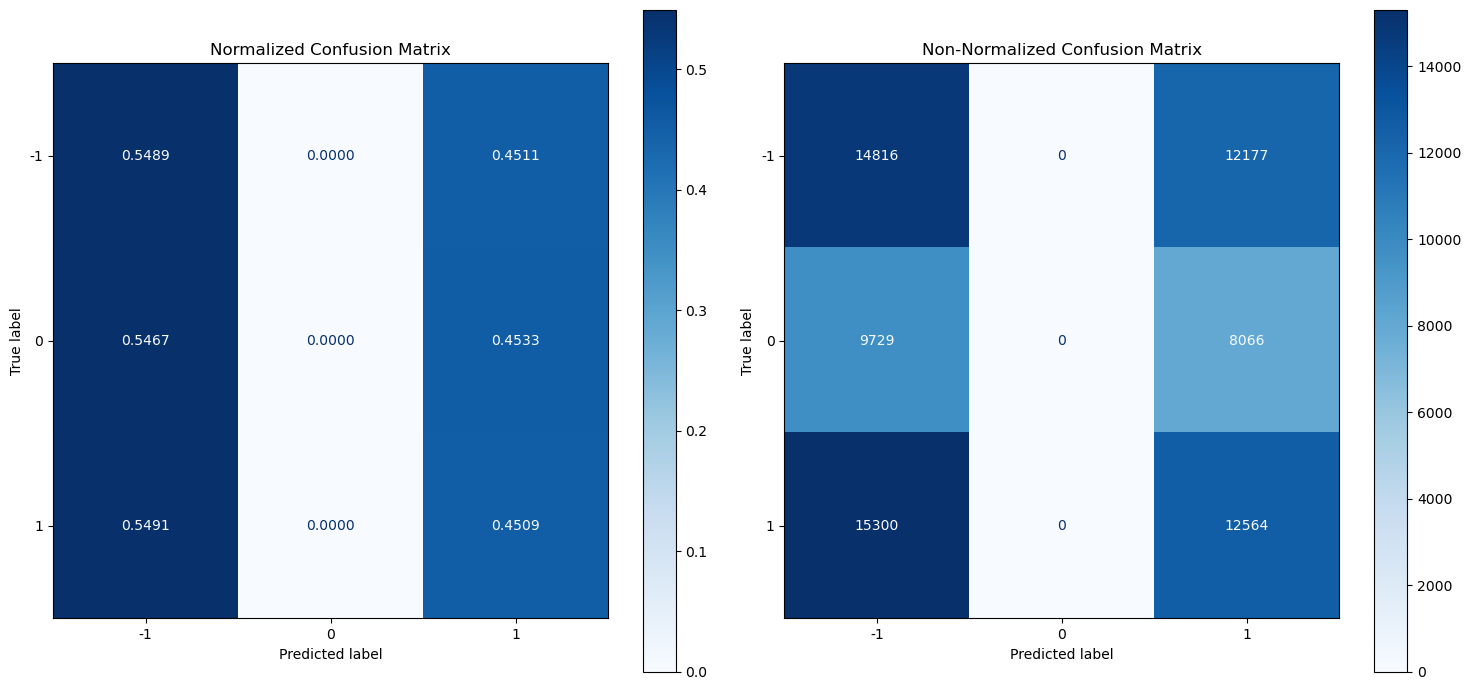

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrices
cm_normalized = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1], normalize='true')
cm_non_normalized = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Plot normalized confusion matrix
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[-1, 0, 1])
disp_normalized.plot(ax=ax[0], cmap=plt.cm.Blues, values_format='0.4f')
ax[0].set_title('Normalized Confusion Matrix')

# Plot non-normalized confusion matrix
disp_non_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_non_normalized, display_labels=[-1, 0, 1])
disp_non_normalized.plot(ax=ax[1], cmap=plt.cm.Blues, values_format='d')
ax[1].set_title('Non-Normalized Confusion Matrix')

plt.tight_layout()
plt.show()